In [2002]:
import pyodbc
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')

In [2046]:
# Connect to the Database
cnxn = pyodbc.connect("Driver={SQL Server Native Client 11.0};"
                        "Server=wd02;"
                        "Database=FootPrint;"
                        "Trusted_Connection=yes;")

# QUERY 01: Operations

In [2004]:
df = pd.read_sql_query("DECLARE @from date, @to date;\
    SELECT\
        @from = getdate()\
        ,@to = dateadd(day, 1, getdate());\
\
SELECT CONVERT(varchar,t.completedDateTime,100) Date, w.name warehouse, p.name project, oc.name operationCode, t.employee\
    FROM datex_footprint.Tasks t\
    JOIN datex_footprint.OperationCodes oc\
        ON oc.id = t.operationCodeId\
    JOIN datex_footprint.Warehouses w\
        ON w.id = t.warehouseId\
    JOIN datex_footprint.Projects p\
        ON p.id = t.projectId\
    WHERE t.completedDateTime >= @from AND t.completedDateTime < @to AND (t.employee != 'FootPrintService') AND (t.employee != 'Foot Print Service') and t.statusId = 2", cnxn)

In [2005]:
# Adding Hours
df['Hour'] = pd.to_datetime(df['Date']).dt.hour
df.head()

,Date,warehouse,project,operationCode,employee,Hour
0,Mar 31 2022 6:54AM,19,ACG North America LLC,Receiving,Carlos Chavez,6
1,Mar 31 2022 6:55AM,19,ACG North America LLC,Receiving,Carlos Chavez,6
2,Mar 31 2022 6:55AM,19,ACG North America LLC,Receiving,Carlos Chavez,6
3,Mar 31 2022 6:56AM,19,ACG North America LLC,Receiving,Carlos Chavez,6
4,Mar 31 2022 6:56AM,19,ACG North America LLC,Receiving,Carlos Chavez,6


# WAREHOUSE

In [2006]:
# Group By Warehouse
df_warehouse = df.groupby(['warehouse']).count()[['operationCode']]
df_warehouse.reset_index(inplace=True)
df_warehouse.head()

,warehouse,operationCode
0,10,932
1,102,4
2,12,38
3,15,394
4,16,187


In [2007]:
# Pie Chart
warehouse = df_warehouse['warehouse']
activity = df_warehouse['operationCode']

#plt.subplots(figsize=(8,8))
#plt.pie(activity, labels=warehouse)
#plt.show()

In [2008]:
# Bar Chart
warehouse = df_warehouse['warehouse']
activity = df_warehouse['operationCode']

#plt.subplots(figsize=(8,8))
#plt.bar(warehouse, activity)
#plt.show()

In [2009]:
# Save Data in JSON format
df_warehouse_index = df_warehouse.set_index(['warehouse'])
df_warehouse_index.to_json('data/warehouse.json')
df_warehouse_index.head()

,operationCode
warehouse,
10,932
102,4
12,38
15,394
16,187


### All Operations type

In [2010]:
df_operation = df.groupby(['operationCode']).count()[['project']]
df_operation.reset_index(inplace=True)
df_operation.head()

,operationCode,project
0,Batch Move,54
1,Count,84
2,Create Inventory,2
3,DONE RECEIVING,18
4,DRIVER CHECK IN,36


In [2011]:
# Horizontal Bar Chart
values = df_operation['project']
operation = df_operation['operationCode']

#plt.subplots(figsize=(8,8))
#plt.barh(operation, values)
#plt.gca().invert_yaxis()
#plt.show()

In [2012]:
df_operation.rename(columns={"project": "Tasks"})
df_operation.head()

,operationCode,project
0,Batch Move,54
1,Count,84
2,Create Inventory,2
3,DONE RECEIVING,18
4,DRIVER CHECK IN,36


In [2013]:
# Save Data in JSON format
df_operation = df_operation.rename(columns={"project": "Tasks"})
df_operation_index = df_operation.set_index(['operationCode'])
df_operation_index.to_json('data/operations_type.json')
df_operation_index.head()

,Tasks
operationCode,
Batch Move,54
Count,84
Create Inventory,2
DONE RECEIVING,18
DRIVER CHECK IN,36


### Excluding Operations PICKING and RECEIVING

In [2014]:
df_operation_excluded = df_operation.loc[(df_operation["operationCode"] != 'Picking') &
                                         (df_operation["operationCode"] != 'Receiving')]

In [2015]:
# Save Data in JSON format
df_operation_excluded = df_operation_excluded.rename(columns={"project": "Tasks"})
df_operation_excluded_index = df_operation_excluded.set_index(['operationCode'])
df_operation_excluded_index.to_json('data/operations_type_excluded.json')
df_operation_excluded_index.head()

,Tasks
operationCode,
Batch Move,54
Count,84
Create Inventory,2
DONE RECEIVING,18
DRIVER CHECK IN,36


### Operations per Hour

In [2016]:
df_hours = df.groupby(['Hour']).count()[['operationCode']]
df_hours.reset_index(inplace=True)
df_hours.head()

,Hour,operationCode
0,6,42
1,7,125
2,8,393
3,9,323
4,10,406


In [2017]:
# Bar Chart
hour = df_hours['Hour']
activity = df_hours['operationCode']

#plt.subplots(figsize=(8,8))
#plt.bar(hour, activity)
#plt.xticks(hour)
#plt.show()

In [2018]:
df_hours = df_hours.rename(columns={'operationCode': 'Operations'})
df_hours_index = df_hours.set_index(['Hour'])
df_hours_index.to_json('data/hours.json')
df_hours_index.head()

,Operations
Hour,
6,42
7,125
8,393
9,323
10,406


# PICKING

In [2019]:
# Filtered by Picking
df_picking = df[df['operationCode'] == 'Picking']

In [2020]:
# Grouped by Employee and Hour
df_picking_grouped = df_picking.groupby(['employee', 'Hour']).count()[['operationCode']]
df_picking_grouped.reset_index(inplace=True)
df_picking_grouped.head()

,employee,Hour,operationCode
0,Aisha Cooper,8,7
1,Aisha Cooper,9,8
2,Aisha Cooper,10,6
3,Aisha Cooper,11,4
4,Aisha Cooper,12,5


In [2021]:
# Pivot
df_picking_pivoted = df_picking_grouped.pivot(index='employee', columns='Hour', values='operationCode')
df_picking_pivoted = df_picking_pivoted.fillna(0)
df_picking_pivoted = df_picking_pivoted.rename_axis(None, axis=1)
#df_picking_pivoted.reset_index(inplace=True)

df_picking_pivoted.head()

,7,8,9,10,11,12
employee,,,,,,
Aisha Cooper,0.0,7.0,8.0,6.0,4.0,5.0
Alejandro Aguirre,0.0,0.0,0.0,4.0,9.0,0.0
Andre Nau,0.0,0.0,6.0,0.0,4.0,1.0
Angela Pena,0.0,0.0,0.0,0.0,0.0,11.0
Carlos Gomez,0.0,0.0,0.0,0.0,0.0,25.0


### Save in JSON File

In [2022]:
# Save into JSON
pickers = df_picking_pivoted.T
pickers.to_json('data/pickers.json')
pickers.head()

employee,Aisha Cooper,Alejandro Aguirre,Andre Nau,Angela Pena,Carlos Gomez,Chris Martin,Edilberto Souza,Edwin Perez,Ernest Ferguson,Felix Blanco,...,Omar Robles,Sergio Piura,Shannon Williamson,Shawn Saunders,Thalia Rivera,Wayne Gray,Wendy Medrano,William Trevino Trevino,Yaima Castillo,yudisel tubella
7,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,38.0,0.0,0.0,0.0
8,7.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,4.0,0.0,13.0,0.0,0.0,37.0,0.0,0.0,0.0
9,8.0,0.0,6.0,0.0,0.0,0.0,5.0,7.0,2.0,1.0,...,0.0,12.0,0.0,24.0,1.0,85.0,10.0,0.0,0.0,0.0
10,6.0,4.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,15.0,0.0,1.0,6.0,0.0,0.0,15.0,0.0,15.0,26.0
11,4.0,9.0,4.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,...,0.0,3.0,0.0,8.0,0.0,0.0,85.0,1.0,5.0,27.0


### Picking By Warehouse Function

In [2023]:
# Picking Function
def picking_by_warehouse (warehouse):
    # Filter by warehouse
    df_w = df_picking[df_picking['warehouse'] == warehouse]
    
    # Grouped by Employee and Hour
    df_w_group = df_w.groupby(['employee', 'Hour']).count()[['operationCode']]
    df_w_group.reset_index(inplace=True)
    
    # Pivot
    df_w_pivot = df_w_group.pivot(index='employee', columns='Hour', values='operationCode')
    df_w_pivot = df_w_pivot.fillna(0)
    df_w_pivot = df_w_pivot.rename_axis(None, axis=1)
    
    # Save into JSON
    pickers_df = df_w_pivot.T
    file_name = f'data/pickers_w{warehouse}.json'
    pickers_df.to_json(file_name)

In [2024]:
# Save warehouse data into JSON files
picking_by_warehouse('10')
picking_by_warehouse('12')
picking_by_warehouse('15')
picking_by_warehouse('16')
picking_by_warehouse('18')
picking_by_warehouse('19')
picking_by_warehouse('20')
picking_by_warehouse('21')
picking_by_warehouse('22')

# RECEIVING

In [2025]:
# Filtered by Picking
receiving_df = df[df['operationCode'] == 'Receiving']
receiving_df.head()

,Date,warehouse,project,operationCode,employee,Hour
0,Mar 31 2022 6:54AM,19,ACG North America LLC,Receiving,Carlos Chavez,6
1,Mar 31 2022 6:55AM,19,ACG North America LLC,Receiving,Carlos Chavez,6
2,Mar 31 2022 6:55AM,19,ACG North America LLC,Receiving,Carlos Chavez,6
3,Mar 31 2022 6:56AM,19,ACG North America LLC,Receiving,Carlos Chavez,6
4,Mar 31 2022 6:56AM,19,ACG North America LLC,Receiving,Carlos Chavez,6


In [2026]:
# Grouped by Employee and Hour
receiving_group_df = receiving_df.groupby(['employee', 'Hour']).count()[['operationCode']]
receiving_group_df.reset_index(inplace=True)
receiving_group_df.head()

,employee,Hour,operationCode
0,Angela Pena,12,15
1,Carlos Chavez,6,25
2,Chris Martin,10,24
3,Djenyson Sanon,11,25
4,Djenyson Sanon,12,2


In [2027]:
# Pivot
receiving_pivot_df = receiving_group_df.pivot(index='employee', columns='Hour', values='operationCode')
receiving_pivot_df = receiving_pivot_df.fillna(0)
receiving_pivot_df = receiving_pivot_df.rename_axis(None, axis=1)
#df_picking_pivoted.reset_index(inplace=True)

receiving_pivot_df.head()

,6,7,8,9,10,11,12
employee,,,,,,,
Angela Pena,0.0,0.0,0.0,0.0,0.0,0.0,15.0
Carlos Chavez,25.0,0.0,0.0,0.0,0.0,0.0,0.0
Chris Martin,0.0,0.0,0.0,0.0,24.0,0.0,0.0
Djenyson Sanon,0.0,0.0,0.0,0.0,0.0,25.0,2.0
Felix Blanco,0.0,0.0,23.0,0.0,0.0,0.0,0.0


In [2028]:
# Save into JSON
receivers = receiving_pivot_df.T
receivers.to_json('data/receivers.json')
receivers.head()

C:\Users\jmeza.WOODFIELD\.conda\envs\PythonData\lib\site-packages\IPython\core\displayhook.py:276: UserWarning: Output cache limit (currently 1000 entries) hit.
Flushing oldest 200 entries.
  'Flushing oldest {cull_count} entries.'.format(sz=sz, cull_count=cull_count))


employee,Angela Pena,Carlos Chavez,Chris Martin,Djenyson Sanon,Felix Blanco,Hernando Sanchez,Juan Castro,Juan Morales,Justin Runsdorf,Luci Nicley,Marzetta Bracken,Omar Robles,Sandra Vega,Shannon Williamson,Thalia Rivera,Tyler Gonzales,Yulieth Aguirre
6,0.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,38.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,23.0,0.0,0.0,0.0,0.0,0.0,17.0,0.0,6.0,0.0,134.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,7.0,0.0,0.0,20.0,0.0,0.0,0.0,1.0
10,0.0,0.0,24.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,18.0,3.0,1.0,7.0,0.0,0.0


# INVENTORY

In [2029]:
# Group By Operation Code and Warehouse
cycle_count_df = df.groupby(['operationCode', 'warehouse']).count()[['employee']]
cycle_count_df.reset_index(inplace=True)

In [2030]:
# Filtering by Count, Recount and Inventory Adjustment
cc_df = cycle_count_df.loc[(cycle_count_df["operationCode"] == 'Count') |
                           (cycle_count_df["operationCode"] == 'Recount') |
                           (cycle_count_df["operationCode"] == 'Inventory Adjustment')]

cc_df = cc_df.rename(columns={'employee': 'count'})

In [2031]:
cc_df_pivot = cc_df.pivot(index='operationCode', columns='warehouse', values='count')

In [2032]:
try:
    cc_df_pivot.rename({'Count': 'Inventory Counts'}, axis='index', inplace=True)
except:
    print('Operation COUNT does not exist yet')
    
try:
    cc_df_pivot.rename({'Recount': 'Discrepancies'}, axis='index', inplace=True)
except:
    print('Operation DISCREPANCIES does not exist yet')
    
try:
    cc_df_pivot.rename({'Inventory Adjustment': 'Inventory Adjustments'}, axis='index', inplace=True)
except:
    print('Operation INVENTORY ADJUSTMENT does not exist yet')

In [2033]:
cc_df_pivot = cc_df_pivot.fillna(0)
cc_df_pivot.to_json('data/cycle_count.json')
cc_df_pivot.head()

warehouse,10,15,19,20
operationCode,,,,
Inventory Counts,34.0,14.0,7.0,29.0
Inventory Adjustments,2.0,0.0,1.0,1.0
Discrepancies,0.0,0.0,0.0,1.0


# QUERY 02: Open Outbounds

In [2034]:
df_02 = pd.read_sql_query("SELECT DISTINCT w.name warehouse, p.name project, s.lookupCode shipment_number, s.createdSysDateTime\
    FROM datex_footprint.shipments s\
    LEFT JOIN datex_footprint.ShipmentOrderLookup sol\
        on sol.shipmentId = s.id\
    LEFT JOIN datex_footprint.orders o\
        on o.id = sol.orderId\
    LEFT JOIN datex_footprint.Projects p\
        on p.id = o.projectId\
    LEFT JOIN datex_footprint.warehouses w\
        on w.id = isnull(s.actualWarehouseId, s.expectedWarehouseId)\
    WHERE s.statusId in (1, 2, 4) and s.typeId = 2\
    ORDER BY createdSysDateTime", cnxn)

In [2035]:
df_02.head()

,warehouse,project,shipment_number,createdSysDateTime
0,17,"TherapeuticsMD, Inc.",489832,2017-07-26 09:09:09.197
1,19,"Novadoz Pharmaceuticals, LLC",1901075,2019-09-30 10:50:10.143
2,10,"Chadwick Pharmaceuticals, Inc.",2167054,2019-11-14 16:36:44.793
3,10,Eywa Pharma Inc.,2475492,2020-01-22 13:20:13.063
4,10,Eywa Pharma Inc.,2475493,2020-01-22 13:20:13.447


In [2036]:
df_02['age_order'] = pd.Timestamp.now() - df_02['createdSysDateTime']
df_02.head()

,warehouse,project,shipment_number,createdSysDateTime,age_order
0,17,"TherapeuticsMD, Inc.",489832,2017-07-26 09:09:09.197,1709 days 03:34:52.222775
1,19,"Novadoz Pharmaceuticals, LLC",1901075,2019-09-30 10:50:10.143,913 days 01:53:51.276775
2,10,"Chadwick Pharmaceuticals, Inc.",2167054,2019-11-14 16:36:44.793,867 days 20:07:16.626775
3,10,Eywa Pharma Inc.,2475492,2020-01-22 13:20:13.063,798 days 23:23:48.356775
4,10,Eywa Pharma Inc.,2475493,2020-01-22 13:20:13.447,798 days 23:23:47.972775


In [2037]:
df_02['age_order_days'] = df_02['age_order'].dt.components['days']
df_02['age_order_hours'] = df_02['age_order'].dt.components['hours']
df_02.head()

,warehouse,project,shipment_number,createdSysDateTime,age_order,age_order_days,age_order_hours
0,17,"TherapeuticsMD, Inc.",489832,2017-07-26 09:09:09.197,1709 days 03:34:52.222775,1709,3
1,19,"Novadoz Pharmaceuticals, LLC",1901075,2019-09-30 10:50:10.143,913 days 01:53:51.276775,913,1
2,10,"Chadwick Pharmaceuticals, Inc.",2167054,2019-11-14 16:36:44.793,867 days 20:07:16.626775,867,20
3,10,Eywa Pharma Inc.,2475492,2020-01-22 13:20:13.063,798 days 23:23:48.356775,798,23
4,10,Eywa Pharma Inc.,2475493,2020-01-22 13:20:13.447,798 days 23:23:47.972775,798,23


In [2038]:
bins =[-1,1,2,3,7,30,60, 90,365, 730,10000]
bin_names = ['24 Hours', '48 Hours', '72 Hours', '1 Week', '1 Month', '2 Months', '3 Months', '1 Year', '2 Years', 'More than 2 years']

df_02['age_group'] = pd.cut(df_02['age_order_days'], bins, labels=bin_names)

In [2039]:
df_02_grouped = df_02.groupby(['age_group'])[['project']].count()

In [2040]:
df_02_grouped = df_02_grouped.rename(columns={'project': 'orders'})

In [2041]:
df_02_grouped

,orders
age_group,
24 Hours,950
48 Hours,210
72 Hours,81
1 Week,307
1 Month,949
2 Months,646
3 Months,630
1 Year,2215
2 Years,1003


### Save in JSON File

In [2042]:
open_outbounds = df_02_grouped
open_outbounds.to_json('data/open_outbounds.json')
open_outbounds

,orders
age_group,
24 Hours,950
48 Hours,210
72 Hours,81
1 Week,307
1 Month,949
2 Months,646
3 Months,630
1 Year,2215
2 Years,1003


<AxesSubplot:ylabel='age_group'>

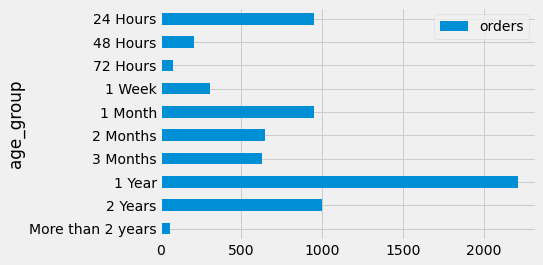

In [2043]:
df_02_grouped = df_02_grouped.iloc[::-1]
df_02_grouped.plot.barh()

# QUERY 3: Picking Performance

In [2052]:
df03 = pd.read_sql_query("DECLARE @from date, @to date;\
                          SELECT @from = getdate(), @to = dateadd(day, 1, getdate());\
    SELECT t.completedDateTime Date, oc.name Operation, w.name Warehouse,\
           p.name Project, m.lookupCode Material, employee Employee, s.lookupCode Shipment, isnull(s.waveId, ps.waveId) Wave,\
           ordersPerWave.shipmentsCount, lc.name Location\
    FROM datex_footprint.Tasks t\
        join datex_footprint.OperationCodes oc\
            on oc.id = t.operationCodeId\
        left join datex_footprint.Warehouses w\
            on w.id = t.warehouseId\
        left join datex_footprint.Projects p\
            on p.id = t.projectId\
        left join datex_footprint.Materials m\
            on m.id = t.materialId\
        left join datex_footprint.Shipments s\
            on s.id = t.shipmentId\
        left join datex_footprint.PickSlips ps\
            on ps.id = t.pickSlipId\
        left join datex_footprint.LocationContainers lc\
            on lc.id = t.expectedSourceLocationId\
        outer apply (\
            select\
                count(distinct tt.shipmentId) shipmentsCount\
                from datex_footprint.waves ww\
                    inner join datex_footprint.PickSlips ppss\
                    inner join datex_footprint.tasks tt\
                        on tt.operationCodeId = 8 and tt.pickSlipId = ppss.id\
                        on ppss.waveId = ww.id\
                where ww.id = isnull(s.waveId, ps.waveId)) ordersPerWave\
    where t.completedDateTime >= @from and t.completedDateTime < @to and t.statusId = 2\
    and t.operationCodeId in (8, 39, 2064, 2065) and t.employee != 'Foot Print Service'\
    order by s.lookupCode, t.completedDateTime", cnxn)

In [2054]:
df03.tail()

,Date,Operation,Warehouse,Project,Material,Employee,Shipment,Wave,shipmentsCount,Location
2585,2022-03-31 12:23:51.393,Scanned Shipment,16,WHC Labs bvba,None,Juan Castro,WHC-7822920,232666,1,None
2586,2022-03-31 12:24:59.287,Picking,16,WHC Labs bvba,USA.SP.0.31,Juan Castro,WHC-7822920,232666,1,None
2587,2022-03-31 12:25:07.350,Picking,16,WHC Labs bvba,USA.SP.0.31,Juan Castro,WHC-7822920,232666,1,None
2588,2022-03-31 12:25:34.180,Picking,16,WHC Labs bvba,USA.SP.0.31,Juan Castro,WHC-7822920,232666,1,None
2589,2022-03-31 12:25:50.040,Picking,16,WHC Labs bvba,USA.SP.0.31,Juan Castro,WHC-7822920,232666,1,None


In [2077]:
df03_group = df03.groupby(['Warehouse', 'Shipment', 'Operation', 'Date'])[['Project']].count().sort_values(['Warehouse', 'Shipment', 'Date'])

In [2078]:
df03_group.to_json('data/performance.json')
df03_group

Project
Warehouse Shipment   Operation        Date                            
10        0085556043 Scanned Shipment 2022-03-31 12:52:10.180        1
                                      2022-03-31 12:52:14.850        1
                     Picking          2022-03-31 12:52:30.320        1
                                      2022-03-31 12:52:47.660        1
                                      2022-03-31 12:53:38.170        1
...                                                                ...
22        609798.1   Picking          2022-03-31 14:51:55.833        1
                                      2022-03-31 14:52:17.177        1
                                      2022-03-31 14:52:36.553        1
                                      2022-03-31 14:52:58.133        1
                                      2022-03-31 14:53:24.180        1

[2316 rows x 1 columns]

In [2044]:
# Close connection
cnxn.close()